---
## 따릉이 데이터 분석을 통한 이용량 예측
### 데이터 columns 기본 정보
- id 고유 id
- hour 시간
- temperature 기온
- precipitation 비가 오지 않았으면 0, 비가 오면 1
- windspeed 풍속(평균)
- humidity 습도
- visibility 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
- ozone 오존
- pm10 미세먼지(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
- pm2.5 미세먼지(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
- count 시간에 따른 따릉이 대여 수
---
### 방향성
- 회귀 방식을 사용, 데이터를 정제하고 예측 모델을 사용
- KNN, Decsion Tree + 앙상블 모델
- linear[rigde, lasso, Elastic-net]
- 데이터 scaling : 범위가 다를 가능성 농후
- ?, 0 과 같은 결측치 역시 대체 => 타 콜럼의 성격을 확인하고 대체
---

---
### 모듈 로딩 및 데이터 불러오기
---

In [75]:
from sklearn.utils import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression,Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor,ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.experimental  import enable_iterative_imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
import seaborn as sns
from custom_function import *
import warnings
warnings.filterwarnings('ignore')

In [21]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')
train['data_cd'] = 'train'
test['data_cd'] = 'test'
ttareun_data = pd.concat([train, test])

---
### 결측치 확인
---

In [22]:
ttareun_data.info()
print()
for i in ttareun_data.columns:
    print(ttareun_data[i].value_counts())
#Insight!
#얘네 모두 다 다른 자전거네

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2174 entries, 0 to 714
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      2174 non-null   int64  
 1   hour                    2174 non-null   int64  
 2   hour_bef_temperature    2171 non-null   float64
 3   hour_bef_precipitation  2171 non-null   float64
 4   hour_bef_windspeed      2164 non-null   float64
 5   hour_bef_humidity       2171 non-null   float64
 6   hour_bef_visibility     2171 non-null   float64
 7   hour_bef_ozone          2063 non-null   float64
 8   hour_bef_pm10           2047 non-null   float64
 9   hour_bef_pm2.5          2021 non-null   float64
 10  count                   1459 non-null   float64
 11  data_cd                 2174 non-null   object 
dtypes: float64(9), int64(2), object(1)
memory usage: 220.8+ KB

3       1
2162    1
2179    1
2178    1
2176    1
       ..
1095    1
1094    1
1090   

##### [1] 걍 모든 결측치를 missforest로 채우고 outlier만 제거?

In [24]:
#하기 전에 id와 index는 삭제
ttareun_data.drop(['id', 'data_cd'],axis=1, inplace=True)

In [25]:
ttareun_data

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0
...,...,...,...,...,...,...,...,...,...,...
710,1,24.6,0.0,2.4,60.0,1745.0,NaN,NaN,NaN,NaN
711,1,18.1,0.0,1.0,55.0,2000.0,NaN,NaN,NaN,NaN
712,9,23.3,0.0,2.3,66.0,1789.0,0.020,17.0,15.0,NaN
713,16,27.0,0.0,1.6,46.0,1956.0,0.032,40.0,26.0,NaN


In [28]:
#성능이 missForest를 사용해서 결측치를 대체하는 것이 올바름직함
from missingpy import MissForest
imputer = MissForest()
imputed_data = imputer.fit_transform(ttareun_data)


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


In [30]:
ttareun_data_df=  pd.DataFrame(imputed_data,columns=ttareun_data.columns)
ttareun_data_df

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,20.0,16.3,1.0,1.5,89.0,576.0,0.02700,76.00,33.00,49.00
1,13.0,20.1,0.0,1.4,48.0,916.0,0.04200,73.00,40.00,159.00
2,6.0,13.9,0.0,0.7,79.0,1382.0,0.03300,32.00,19.00,26.00
3,23.0,8.1,0.0,2.7,54.0,946.0,0.04000,75.00,64.00,57.00
4,18.0,29.5,0.0,4.8,7.0,2000.0,0.05700,27.00,11.00,431.00
...,...,...,...,...,...,...,...,...,...,...
2169,1.0,24.6,0.0,2.4,60.0,1745.0,0.02253,35.83,25.32,60.60
2170,1.0,18.1,0.0,1.0,55.0,2000.0,0.02258,32.34,19.90,77.08
2171,9.0,23.3,0.0,2.3,66.0,1789.0,0.02000,17.00,15.00,120.80
2172,16.0,27.0,0.0,1.6,46.0,1956.0,0.03200,40.00,26.00,158.83


In [31]:
ttareun_data_df.info()
#결측치가 제거된 상태

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2174 entries, 0 to 2173
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   hour                    2174 non-null   float64
 1   hour_bef_temperature    2174 non-null   float64
 2   hour_bef_precipitation  2174 non-null   float64
 3   hour_bef_windspeed      2174 non-null   float64
 4   hour_bef_humidity       2174 non-null   float64
 5   hour_bef_visibility     2174 non-null   float64
 6   hour_bef_ozone          2174 non-null   float64
 7   hour_bef_pm10           2174 non-null   float64
 8   hour_bef_pm2.5          2174 non-null   float64
 9   count                   2174 non-null   float64
dtypes: float64(10)
memory usage: 170.0 KB


In [35]:
ttareun_data_df['hour_bef_precipitation'] = ttareun_data_df['hour_bef_precipitation'].astype('category')
ttareun_data_df['hour'] = ttareun_data_df['hour'].astype('category')

In [50]:
ttareun_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2174 entries, 0 to 2173
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   hour                    2174 non-null   category
 1   hour_bef_temperature    2174 non-null   float64 
 2   hour_bef_precipitation  2174 non-null   category
 3   hour_bef_windspeed      2174 non-null   float64 
 4   hour_bef_humidity       2174 non-null   float64 
 5   hour_bef_visibility     2174 non-null   float64 
 6   hour_bef_ozone          2174 non-null   float64 
 7   hour_bef_pm10           2174 non-null   float64 
 8   hour_bef_pm2.5          2174 non-null   float64 
 9   count                   2174 non-null   float64 
dtypes: category(2), float64(8)
memory usage: 141.1 KB


In [32]:
check_na(ttareun_data,target=['?',0])
print('해당 데이터는 충분히 가능한 데이터임')
#바람이 안 불 수 있으므로 ㅇㅈ


hour열에 0값이 90개 있습니다.
hour_bef_precipitation열에 0값이 2088개 있습니다.
hour_bef_windspeed열에 0값이 4개 있습니다.
결측치가 있습니다
해당 데이터는 충분히 가능한 데이터임


---
#### 상관분석
##### 예측의 경우, 변수간 상관관계가 있을 시에는 제외하는 것이 좋다.
---

In [39]:
cor_df= ttareun_data_df.corr().abs()


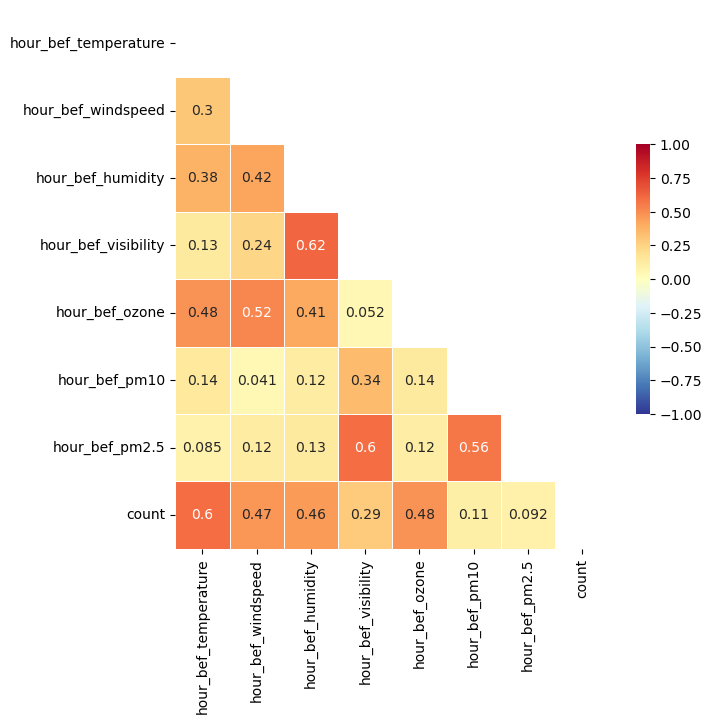

In [40]:
fig, ax = plt.subplots( figsize=(7,7) )

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(cor_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(cor_df, 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()
#변수 간 상관관계가 커보이지는 않음
#온도 가 count의 가장 큰 상관관계를 가짐

---
### 이상치 및 분포 확인
---

<Figure size 1000x1000 with 0 Axes>

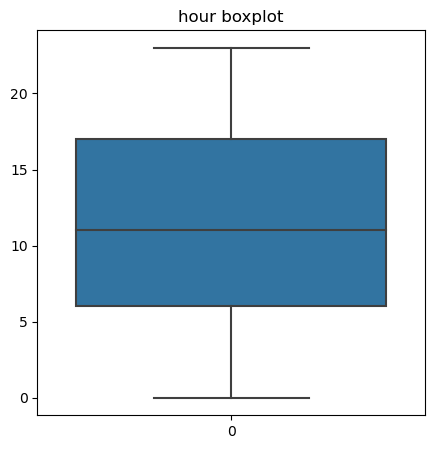

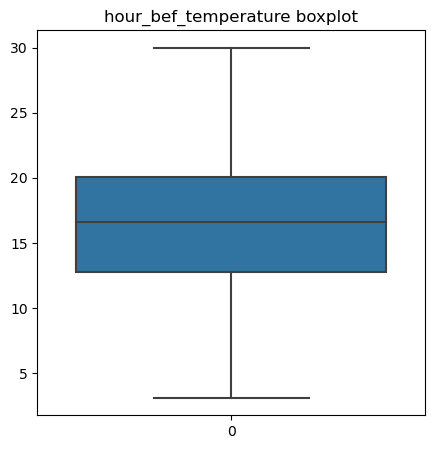

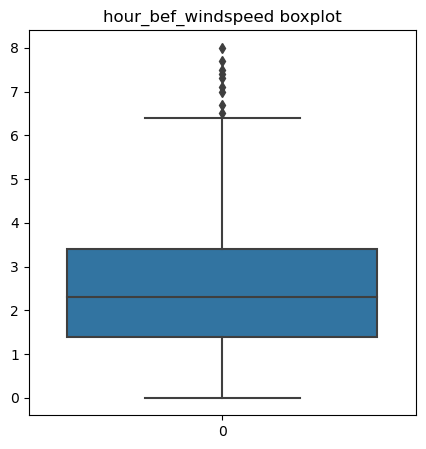

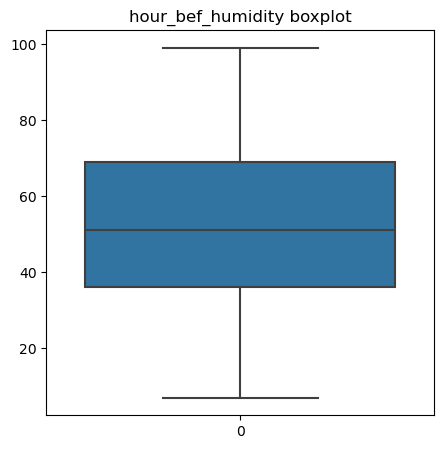

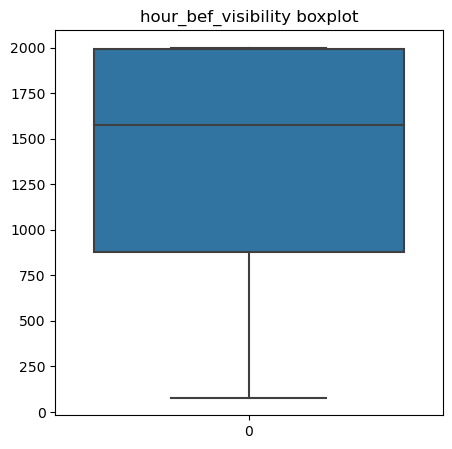

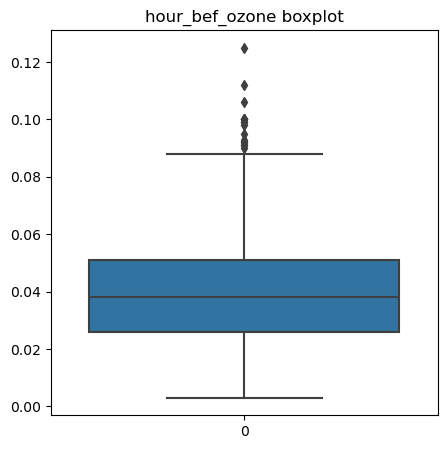

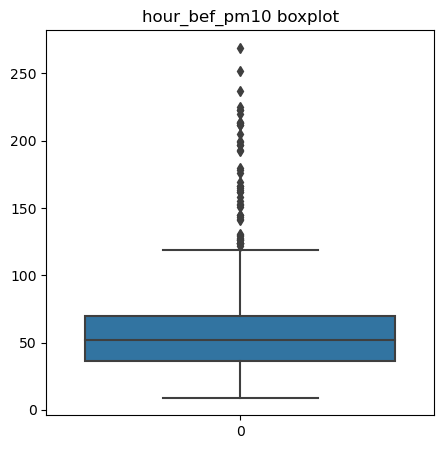

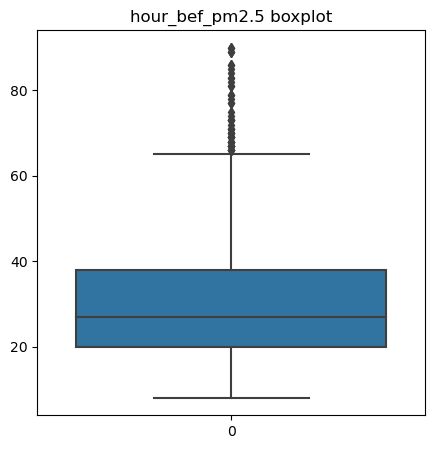

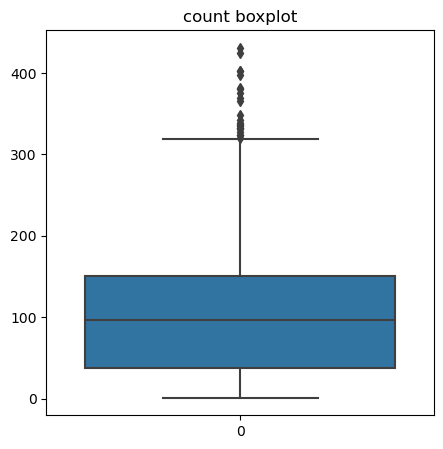

In [21]:
plt.figure(figsize=(10,10))
col_data = ttareun_df.drop(['hour_bef_precipitation'],axis=1)
                  
def check_box(data):
    for i in data.columns:
        plt.figure(figsize = (5,5))
        sns.boxplot(data=data[i])
        plt.title(f'{i} boxplot')
        plt.show()
check_box(col_data)
# 바람온도 미세먼지에서 이상치가 확인됨

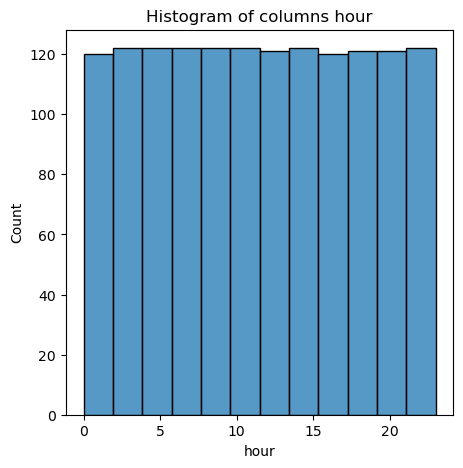

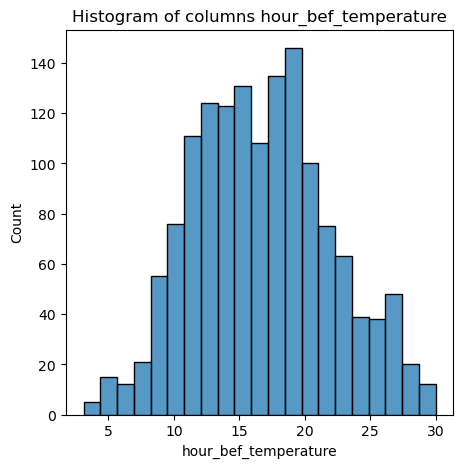

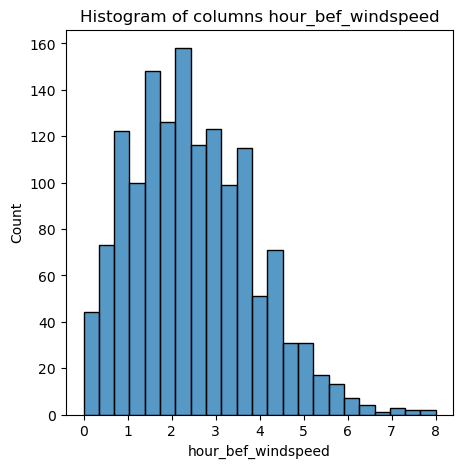

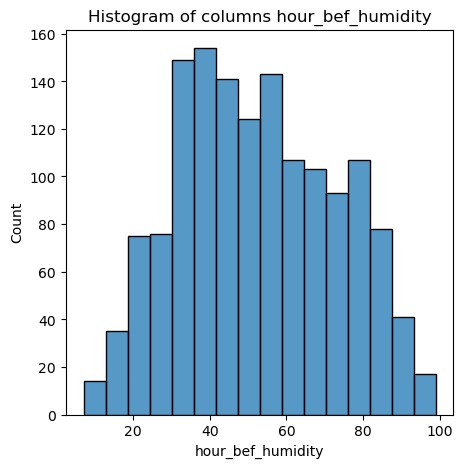

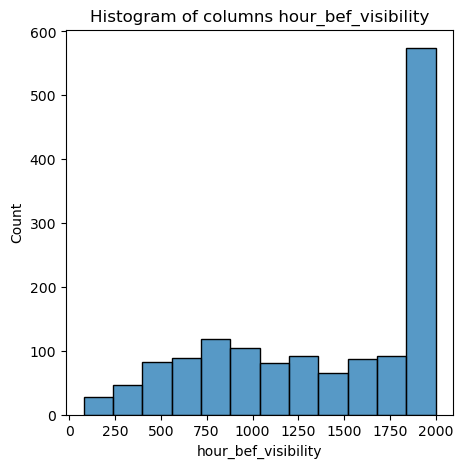

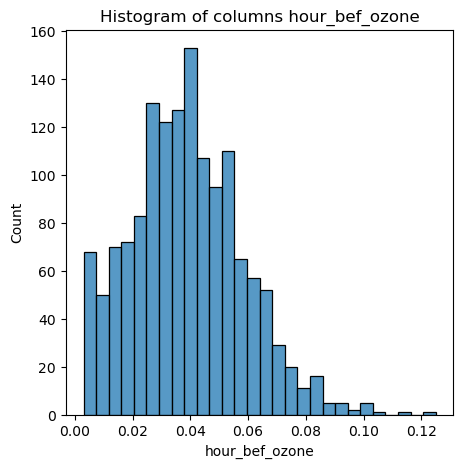

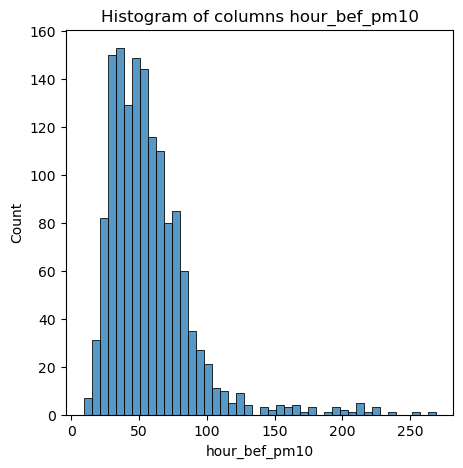

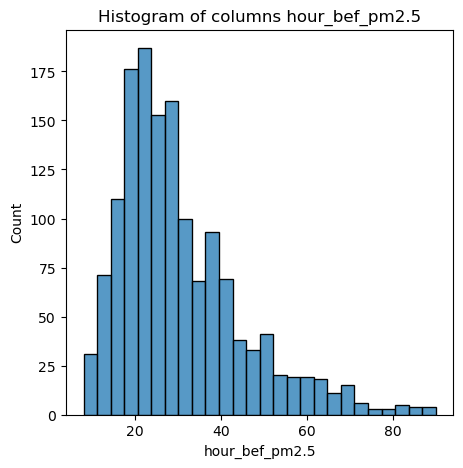

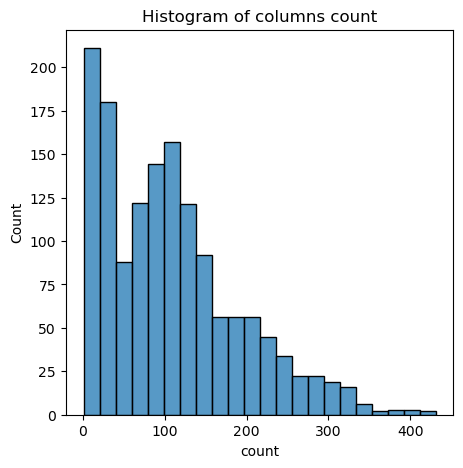

In [22]:
def check_distribution(data):
    for i in data.columns:
        plt.figure(figsize = (5,5))
        #열 데이터별 분포확인
        sns.histplot(data=data[i])
        # 그래프 타이틀 추가
        plt.title(f'Histogram of columns {i}')
        # 그래프 출력
        plt.show()
check_distribution(col_data)
#시간대의 분포가 균등!

In [47]:
ttareun_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2174 entries, 0 to 2173
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   index                   2174 non-null   int64   
 1   hour                    2174 non-null   category
 2   hour_bef_temperature    2174 non-null   float64 
 3   hour_bef_precipitation  2174 non-null   category
 4   hour_bef_windspeed      2174 non-null   float64 
 5   hour_bef_humidity       2174 non-null   float64 
 6   hour_bef_visibility     2174 non-null   float64 
 7   hour_bef_ozone          2174 non-null   float64 
 8   hour_bef_pm10           2174 non-null   float64 
 9   hour_bef_pm2.5          2174 non-null   float64 
 10  count                   2174 non-null   float64 
dtypes: category(2), float64(8), int64(1)
memory usage: 158.1 KB


---
### target 이상치 제거 예측
---

In [77]:
from sklearn.ensemble import IsolationForest
model = IsolationForest(random_state=12)
model.fit(ttareun_data_df)
y_pred = model.predict(ttareun_data_df)
df_all_clean = ttareun_data_df[y_pred != -1]
df_all_clean

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
1,13.0,20.1,0.0,1.4,48.0,916.0,0.04200,73.00,40.00,159.00
2,6.0,13.9,0.0,0.7,79.0,1382.0,0.03300,32.00,19.00,26.00
5,2.0,13.6,0.0,1.7,80.0,1073.0,0.02700,34.00,15.00,39.00
6,3.0,10.6,0.0,1.5,58.0,1548.0,0.03800,62.00,33.00,23.00
7,21.0,16.0,0.0,6.0,21.0,1961.0,0.05000,90.00,28.00,146.00
...,...,...,...,...,...,...,...,...,...,...
2169,1.0,24.6,0.0,2.4,60.0,1745.0,0.02253,35.83,25.32,60.60
2170,1.0,18.1,0.0,1.0,55.0,2000.0,0.02258,32.34,19.90,77.08
2171,9.0,23.3,0.0,2.3,66.0,1789.0,0.02000,17.00,15.00,120.80
2172,16.0,27.0,0.0,1.6,46.0,1956.0,0.03200,40.00,26.00,158.83


In [78]:
#타겟, 피쳐분리
target_data = df_all_clean['count']
feature_data = df_all_clean.drop(['count'],axis =1)
#minmaxscaler를 통해 scaling

ss = MinMaxScaler()
feature_fit = ss.fit_transform(feature_data)
feature_fit.shape

(1853, 9)

In [79]:
feature_data = pd.DataFrame(feature_fit, columns= feature_data.columns)
feature_data

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,0.565217,0.540268,0.0,0.181818,0.463415,0.391695,0.3900,0.371951,0.578947
1,0.260870,0.332215,0.0,0.090909,0.841463,0.653199,0.3000,0.121951,0.210526
2,0.086957,0.322148,0.0,0.220779,0.853659,0.479798,0.2400,0.134146,0.140351
3,0.130435,0.221477,0.0,0.194805,0.585366,0.746352,0.3500,0.304878,0.456140
4,0.913043,0.402685,0.0,0.779221,0.134146,0.978114,0.4700,0.475610,0.368421
...,...,...,...,...,...,...,...,...,...
1848,0.043478,0.691275,0.0,0.311688,0.609756,0.856902,0.1953,0.145305,0.321404
1849,0.043478,0.473154,0.0,0.129870,0.548780,1.000000,0.1958,0.124024,0.226316
1850,0.391304,0.647651,0.0,0.298701,0.682927,0.881594,0.1700,0.030488,0.140351
1851,0.695652,0.771812,0.0,0.207792,0.439024,0.975309,0.2900,0.170732,0.333333


In [80]:
# 데이터 내 train, test split 시간대에 따라 분류
X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size= 0.2, random_state=2,stratify=feature_data['hour'])

In [83]:
#optuna에 의한 하이퍼파라미터 최적화
import optuna
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int("n_estimators", 10, 1000,50),
        'max_depth': trial.suggest_int("max_depth", 2, 32, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'random_state' :42
    }
    rf = RandomForestRegressor(**param)
    mse = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    return mse
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 100)


[I 2023-03-22 21:23:59,258] A new study created in memory with name: no-name-a3a87c2d-e3b6-46f6-9a17-f9036f00d19f
[I 2023-03-22 21:24:02,652] Trial 0 finished with value: -1075.5827023332401 and parameters: {'n_estimators': 328, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 0 with value: -1075.5827023332401.
[I 2023-03-22 21:24:12,174] Trial 1 finished with value: -1027.7819702823942 and parameters: {'n_estimators': 886, 'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 1 with value: -1027.7819702823942.
[I 2023-03-22 21:24:12,903] Trial 2 finished with value: -983.6314718601037 and parameters: {'n_estimators': 57, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 2 with value: -983.6314718601037.
[I 2023-03-22 21:24:13,913] Trial 3 finished with value: -999.0481336370518 and parameters: {'n_estimators': 83, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 2 with val

In [85]:
print('Best trial:', study.best_trial.params)
best_params = study.best_params

Best trial: {'n_estimators': 147, 'max_depth': 32, 'min_samples_split': 4, 'min_samples_leaf': 2}


In [100]:
rf = RandomForestRegressor(**best_params)
rf.fit(X_train, y_train)
pred=rf.predict(X_test)
mean_squared_error(pred, y_test)
print(pred)

[228.768569   135.95230855  51.66114939  11.06737123 146.84799838
  39.3665423   48.72912455 180.37799185  27.76485261  35.45152208
  52.19908228 132.13296121 137.21075016  93.14364893  18.60431762
  75.07283771 135.27201334  36.10284184 109.6519059   54.88471753
 109.84113379 128.75999892 138.41910188 194.15061251 134.44675445
  90.12014423 111.88257264  44.86121974 143.96639342 193.96256133
 123.99510312 111.35304551 121.02230612 229.06934543 138.5944638
  84.42810226  54.12930296  19.5960958  141.78900475 205.74668027
  15.32073985 143.19549725 145.85418918 111.17716084  19.75683511
  24.29019234  85.97722805 101.0116346   90.55833787  11.29025008
  18.85572773 321.92373383 161.7000379  121.28507758  36.58493413
 118.49964135 208.59694218 148.64773243 263.77745851 144.61971574
 254.16370538  73.23491173 226.77627057  13.76697765 289.95557013
 218.61791138  88.15905086 186.05655685 114.48255329 155.11594979
 166.03614901  47.01316003 303.24395033  56.75464124  44.63071002
  87.193636

In [104]:
test = pd.read_csv('test.csv')
test['hour'] = test['hour'].astype('category')
test['hour_bef_precipitation'] = test['hour_bef_precipitation'].astype('category')
test.drop('id',axis =1,inplace = True)
imputer = MissForest()
imputed_data = imputer.fit_transform(test)
mss =MinMaxScaler()
scaled_data = mss.fit_transform(imputed_data)
test = pd.DataFrame(scaled_data, columns = test.columns)


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


In [105]:
test

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,0.304348,0.317708,0.0,0.220339,0.547619,0.441836,0.281481,0.411765,0.322581
1,0.739130,0.802083,0.0,0.915254,0.202381,0.781217,0.429630,0.470588,0.467742
2,0.565217,0.229167,1.0,0.355932,0.940476,0.035752,0.125926,0.317647,0.338710
3,0.260870,0.411458,0.0,0.423729,0.523810,0.565101,0.177778,0.505882,0.500000
4,0.956522,0.000000,1.0,0.576271,0.916667,0.049093,0.281481,0.105882,0.129032
...,...,...,...,...,...,...,...,...,...
710,0.043478,0.520833,0.0,0.406780,0.523810,0.863927,0.220000,0.270235,0.255645
711,0.043478,0.182292,0.0,0.169492,0.464286,1.000000,0.188519,0.298824,0.189194
712,0.391304,0.453125,0.0,0.389831,0.595238,0.887407,0.125926,0.094118,0.129032
713,0.695652,0.645833,0.0,0.271186,0.357143,0.976521,0.214815,0.364706,0.306452


In [106]:
rf.predict(test)

array([ 55.25545076, 194.21800283,  88.29240768,  27.68710917,
        85.36317082, 117.74346898, 116.560636  , 361.12489853,
        22.49565355, 165.38165193, 236.59132718, 260.16136897,
       124.86361484,  43.31334216, 151.07454219, 167.52779883,
        21.64016456, 142.50775332, 349.2647602 , 129.38838403,
       171.68921634,  52.53597425,  16.19657094, 126.9848714 ,
       141.77022805, 100.16234913,  17.74089731,  96.37693068,
        90.2680677 , 151.67545821,  81.4504283 ,  29.02641561,
        71.53036897, 126.96526855, 199.14284483,  25.49494612,
       167.66748232, 115.58500702, 179.47554994,  42.6444987 ,
        58.5837605 , 105.68087501, 195.8694114 ,  72.46144947,
       272.55862704, 127.61320052,  82.21962499,  70.07774741,
        12.57724636,  68.05537302, 201.78948607,  93.18037812,
        43.35093456,  85.26643181, 162.15177834, 109.53802073,
        27.05097992, 151.45464248,  12.85571315,  11.20755318,
        72.78809135,  83.73836681, 248.66106706, 250.13

In [108]:
pred = rf.predict(test)
submission = pd.read_csv('submission.csv')
submission['count'] = pred
submission.to_csv('submission_fin.csv', index=False)

---
#### target이상치 제거X model
---

In [109]:
from sklearn.ensemble import IsolationForest
df_no_target = ttareun_data_df.drop(['count'],axis=1)
model = IsolationForest(random_state=12)
model.fit(df_no_target)
y_pred = model.predict(df_no_target)
df_not_all_clean = df_no_target[y_pred != -1]
df_not_all_clean
df_not_all_clean = pd.concat([df_not_all_clean,ttareun_data_df['count']], join ='inner' ,axis=1) 


In [110]:
df_not_all_clean.reset_index(inplace=True)
df_not_all_clean.drop('index', inplace=True, axis=1)

In [111]:
df_not_all_clean

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,13.0,20.1,0.0,1.4,48.0,916.0,0.04200,73.00,40.00,159.00
1,6.0,13.9,0.0,0.7,79.0,1382.0,0.03300,32.00,19.00,26.00
2,18.0,29.5,0.0,4.8,7.0,2000.0,0.05700,27.00,11.00,431.00
3,2.0,13.6,0.0,1.7,80.0,1073.0,0.02700,34.00,15.00,39.00
4,3.0,10.6,0.0,1.5,58.0,1548.0,0.03800,62.00,33.00,23.00
...,...,...,...,...,...,...,...,...,...,...
1874,1.0,24.6,0.0,2.4,60.0,1745.0,0.02253,35.83,25.32,60.60
1875,1.0,18.1,0.0,1.0,55.0,2000.0,0.02258,32.34,19.90,77.08
1876,9.0,23.3,0.0,2.3,66.0,1789.0,0.02000,17.00,15.00,120.80
1877,16.0,27.0,0.0,1.6,46.0,1956.0,0.03200,40.00,26.00,158.83


In [112]:
#타겟, 피쳐분리
target_data = df_not_all_clean['count']
feature_data = df_not_all_clean.drop(['count'],axis =1)
#minmaxscaler를 통해 scaling

ss = MinMaxScaler()
feature_fit = ss.fit_transform(feature_data)
feature_fit.shape

feature_data = pd.DataFrame(feature_fit, columns= feature_data.columns)
# 데이터 내 train, test split 시간대에 따라 분류
X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size= 0.2, random_state=2,stratify=feature_data['hour'])
#optuna에 의한 하이퍼파라미터 최적화
import optuna
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int("n_estimators", 10, 1000,50),
        'max_depth': trial.suggest_int("max_depth", 2, 32, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'random_state' :42
    }
    rf = RandomForestRegressor(**param)
    mse = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    return mse
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 100)
print('Best trial:', study.best_trial.params)
best_params = study.best_params
rf = RandomForestRegressor(**best_params)
rf.fit(X_train, y_train)
pred=rf.predict(X_test)
mean_squared_error(pred, y_test)
print(pred)

[I 2023-03-22 22:07:53,302] A new study created in memory with name: no-name-3d121e38-50ce-4a28-830b-66045378b471
[I 2023-03-22 22:08:00,410] Trial 0 finished with value: -1028.9464783476626 and parameters: {'n_estimators': 610, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 0 with value: -1028.9464783476626.
[I 2023-03-22 22:08:04,070] Trial 1 finished with value: -2440.894985035565 and parameters: {'n_estimators': 660, 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 0 with value: -1028.9464783476626.
[I 2023-03-22 22:08:12,817] Trial 2 finished with value: -979.3467821164995 and parameters: {'n_estimators': 660, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 2 with value: -979.3467821164995.
[I 2023-03-22 22:08:23,619] Trial 3 finished with value: -982.7030950415465 and parameters: {'n_estimators': 810, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 2 with val

Best trial: {'n_estimators': 260, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 2}
[ 13.82078308 124.6863384  138.48011793 212.54154284  99.24639776
  96.00737637  28.9117125   47.11437811  34.25345818  15.84160495
 246.26419752  83.58182852  89.41898405  93.56568764  47.05209657
 108.33135112 272.60587081  30.73771328 236.61409648 172.95007452
  88.56756164 143.652083    54.00961893 132.41140969 166.55956298
  27.57014579 307.59320272   9.85769816 135.75328791 171.52966969
 145.31973672  19.31562583  84.57703575  10.15416026 106.48720069
  96.32942922 168.21992077  91.10033943  32.2873206   83.50059281
  39.97731691  49.19186845 232.1879645  300.9812514  194.83401037
 202.85808987  86.56203825 182.44914717 186.51327173  98.31318013
  28.7882004  321.26073636 130.22094829  90.15796393 221.87750611
 176.75446148  46.87394165 107.5316511  113.18635226  15.18917059
  93.21572497  11.62879571 123.04119474  20.42677247  94.06130495
  21.58137418 145.20979362 124.60298346 116.

In [116]:
pred=rf.predict(X_test)
mean_squared_error(pred, y_test)


960.5398488092961

In [114]:
pred = rf.predict(test)
submission = pd.read_csv('submission.csv')
submission['count'] = pred
submission.to_csv('submission_fin.csv', index=False)